In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, sampler, Dataset 

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import glob
import os.path as osp
import numpy as np
from PIL import Image

In [4]:
class MOVIES(Dataset):

# A customized data loader for MNIST.\n",
    def __init__(self, root,transform=None,preload=False, train=True):
#             Intialize the MNIST dataset,
#             Args:,
#                 - root: root directory of the dataset
#                 - transform: a custom tranform function
#                 - preload: if preload the dataset into memory
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform
        self.train = train
            
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.jpg'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label)

        # if preload dataset into memory",
        if preload:
            self._preload()

        self.len = len(self.filenames)

    def _preload(self):

#        Preload dataset to memory

        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
#              Get a sample from the dataset

        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)

        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):

#             Total number of samples in the dataset
        return self.len

In [5]:
DataSetFolder = 'datasets/split_drama_posters/train/'
DataSetFolder_test = 'datasets/split_drama_posters/test/'

NUM_TRAIN = 4000
NUM_TOTALIMAGES = 4291

BATCHSIZE = 32 #cifar10 set to 64
R_Mean = .4
G_Mean = .4
B_Mean = .4
R_Std = .01
G_Std = .01
B_Std = .01


In [6]:
## This cell is drafted after Assignment2 Pytorch - but those images were already square!!!!

## to normalize by subtracting the mean RGB vlaue and dividing by the standard deviations of each RGB value
## the Mean and STD are from CIFAR10 dataset
data_transforms = T.Compose([
                T.Resize((32,32)),
                T.ToTensor()])
#                 T.Normalize((R_Mean, G_Mean, B_Mean), (R_Std, G_Std, B_Std))])

poster_train = MOVIES(DataSetFolder, preload=False, transform=data_transforms, train=True)
loader_train = DataLoader(poster_train, batch_size=BATCHSIZE, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

poster_val = MOVIES(DataSetFolder, preload=False, transform=data_transforms, train=True)
loader_val = DataLoader(poster_val, batch_size=BATCHSIZE, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTALIMAGES)))

poster_test = MOVIES(DataSetFolder_test, preload=False, transform=data_transforms, train=False)
loader_test = DataLoader(poster_test, batch_size=BATCHSIZE)

In [7]:
len(poster_train)

4294

tensor(1) tensor(0) tensor(1) tensor(1) tensor(0) tensor(1) tensor(0) tensor(0) tensor(0) tensor(1) tensor(1) tensor(0) tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(0) tensor(0) tensor(1) tensor(1) tensor(0) tensor(0) tensor(1) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0)


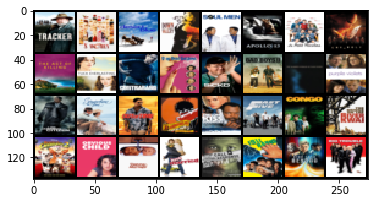

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(loader_train)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(BATCHSIZE)))

In [10]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available(): 
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [11]:
def flatten(x):
    N = x.shape[0] #read in N, C, H, W
    return x.view(N, -1) # "flatten" the C * H * W values into a sing le vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2) 
    print('Before flattening: ', x) 
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


In [12]:
class Flatten(nn.Module):
    def forward(self, x): 
        return flatten(x)

In [13]:
def check_accuracy(loader, model): 
    if loader.dataset.train:
        print('Checking accuracy on validation set') 
    else:
        print('Checking accuracy on test set')

    num_correct = 0
    num_samples = 0
    model.eval() # set model to evaluation mode 
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples , 100 * acc))

In [14]:
def train_part(model, optimizer, epochs=1): 
    """
     - model: A PyTorch Module giving the model to train.
     - optimizer: An Optimizer object we will use to train the model
     - epochs: (Optional) A Python integer giving the number of epochs to train for
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device) # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train() # put model to training mode
            x = x.to(device=device, dtype=dtype) # move to device, e.
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            # Zero out all of the gradients for the variables which th
            # will update.
            
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the
            # respect to each  parameter of the model.
            loss.backward()
            
            # Actually update the parameters of the model using the gr
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %s' % (e))
                print('Iteration %d, loss = %.4f' % (t, loss.item())) 
                check_accuracy(loader_val, model)
                print()

In [15]:
channel_1 = 32
channel_2 = 16
channel_3 = 32
channel_4 = 16
learning_rate = 1e-2
in_channel = 3
num_classes = 2
num_features = 3*32*32

model = nn.Sequential(
#Layer 1
    nn.Conv2d(in_channel, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.BatchNorm2d(channel_1),
#Layer2
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(channel_2),
    #Layer2.2 ====> added in as an experiment
    nn.Conv2d(channel_2, channel_3, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.BatchNorm2d(channel_3),
#Layer3
    nn.Conv2d(channel_3, channel_4, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.BatchNorm2d(channel_4),
#Layer4
    Flatten(),
    nn.Linear((channel_4*32*32), num_classes)
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

train_part(model, optimizer, epochs=10)

Epoch: 0
Iteration 0, loss = 0.7400
Checking accuracy on validation set
Got 291 / 291 correct (100.00)

Epoch: 0
Iteration 100, loss = 0.6531
Checking accuracy on validation set
Got 120 / 291 correct (41.24)

Epoch: 1
Iteration 0, loss = 0.6738
Checking accuracy on validation set
Got 18 / 291 correct (6.19)



KeyboardInterrupt: 